Classification Report on Test Set:
              precision    recall  f1-score   support

       False       0.96      0.99      0.98     17512
        True       0.85      0.60      0.71      1714

    accuracy                           0.96     19226
   macro avg       0.91      0.80      0.84     19226
weighted avg       0.95      0.96      0.95     19226

Feature names during training: Index(['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'hypertension_1',
       'heart_disease_1', 'gender_Male'],
      dtype='object')


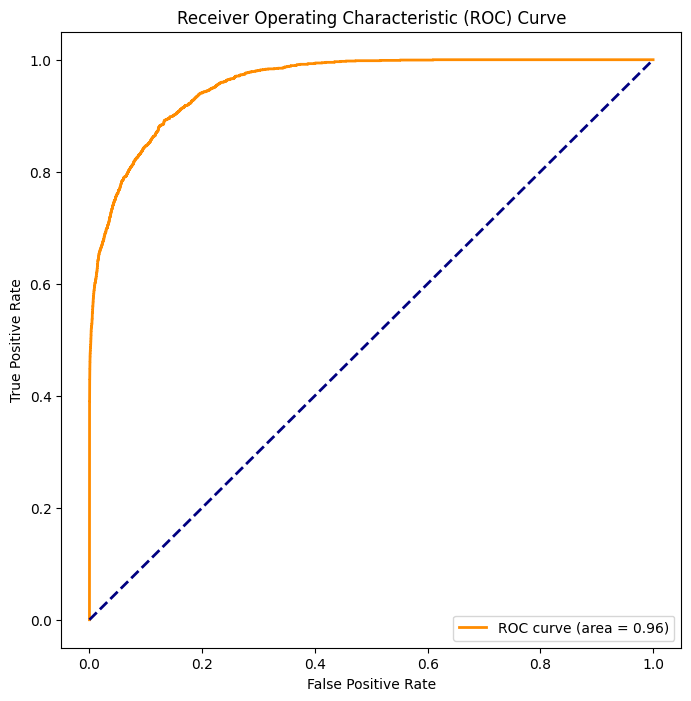

5-fold Cross-Validation AUC Scores: [0.95898978 0.96008983 0.96387925 0.95944672 0.96215016]
Mean AUC: 0.9609111457573778


In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import joblib

# Global variable to store feature names
feature_names = None

# Read the dataset
df = pd.read_csv('diabetes_prediction_dataset.csv')

# Remove duplicate rows in the dataset
df.drop_duplicates(inplace=True)

# Filter out rows with gender 'Other'
df = df[df['gender'] != 'Other']

# Drop the 'smoking_history' column
df.drop(['smoking_history'], axis=1, inplace=True)

# Use pd.get_dummies to one-hot encode remaining categorical columns
df = pd.get_dummies(df, columns=['hypertension', 'heart_disease', 'gender', 'diabetes'], drop_first=True)

# Separate features (X) and target variable (y)
X = df.drop(['diabetes_1'], axis=1)
y = df['diabetes_1']

# Rescale features using Min-Max scaling to ensure uniform scale
scaler = MinMaxScaler(feature_range=(0, 1))
X_rescaled = scaler.fit_transform(X)
X = pd.DataFrame(data=X_rescaled, columns=X.columns)

# Set the feature names after training
feature_names = X.columns

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Initialize Logistic Regression model
log_reg = LogisticRegression()

# Build the logistic regression model using the training data
log_reg.fit(X_train, y_train)

# Save the trained model to a file named 'model.pkl'
joblib.dump(log_reg, 'model.pkl')

# Predict values on the test set
y_pred = log_reg.predict(X_test)

# Print classification report to evaluate model performance
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

# Get predicted probabilities for positive class
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Print the feature names
print("Feature names during training:", feature_names)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Apply k-fold cross-validation
k_folds = 5
cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=21)

# Perform cross-validation and print the results
cv_results = cross_val_score(log_reg, X, y, cv=cv, scoring='roc_auc')
print(f"{k_folds}-fold Cross-Validation AUC Scores: {cv_results}")
print(f"Mean AUC: {cv_results.mean()}")


In [3]:
# Create a new input sample for testing
new_input = pd.DataFrame({
    'age': [86],
    'bmi': [30],
    'HbA1c_level': [8],
    'blood_glucose_level': [120],
    'hypertension_1': [1 if 1 else 0],
    'heart_disease_1': [1 if 1 else 0],
    'gender_Male': [1 if 1 else 0],
})

# Rescale the new input using the Min-Max scaler
new_input_rescaled = scaler.transform(new_input)
new_input_rescaled_df = pd.DataFrame(data=new_input_rescaled, columns=new_input.columns)

# Predict the output for the new input
prediction = log_reg.predict(new_input_rescaled_df)

# Display the prediction
print("Prediction for the new input:", prediction[0])

Prediction for the new input: True


In [4]:
import pickle
pickle.dump(log_reg, open('model.pkl','wb'))
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)